### making an edge plot

In [1]:
%load_ext autoreload
%autoreload 2
%cd -q ../test/

In [2]:
import matplotlib
#matplotlib.rcParams.update({'font.size': 18, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})
matplotlib.rcParams.update({'text.usetex': True})
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib.pyplot as plt

In [3]:
%%writefile experiment_duck.py

from __future__ import division, print_function

tag = 'example_'

import os
import numpy as np
from SparseEdges import EdgeFactory
ef = EdgeFactory('default_param.py')

import numpy as np
np.set_printoptions(precision=4)#, suppress=True)

for filename in ['elephant.jpg', 'bird.jpg']:#'zebra.jpg', 'duck.jpg', 'duck2.jpg', , 'seagull.jpg']:
    print (filename)
    # defining input image
    image = ef.imread('../database/' + filename)

    ef.pe.N = 2048
    ef.set_size(image)
    ef.pe.do_mask = False
    image = ef.normalize(image, center=True)
    #print image.mean(), image.std()

    locked = False
    matname = 'data_cache/' + tag + filename + '.npy'
    try:
        edges = np.load(matname)
    except Exception:
        if not os.path.isfile(matname + '_lock'):
            open(matname + '_lock', 'w').close()
            print('Doing ' + matname)
            edges, C_res = ef.run_mp(image, verbose=True)
            print(edges.shape)
            np.save(matname, edges)    
            os.remove(matname + '_lock')
        else:
            print('locked ' + matname)
            locked = True

    if not locked:
        matname = 'data_cache/' + tag + filename + '_RMSE.npy'
        try:
            RMSE = np.load(matname)
        except Exception:
            if not os.path.isfile(matname + '_lock'):
                open(matname + '_lock', 'w').close()
                print('Doing ' + matname)

                RMSE = np.ones(ef.pe.N)
                image_ = image.copy()
                image_rec = np.zeros_like(image_)
                if ef.pe.do_whitening: image_ = ef.whitening(image_)
                for i_N in range(ef.pe.N):
                    image_rec += ef.reconstruct(edges[:, i_N][:, np.newaxis])
                    RMSE[i_N] =  ((image_-image_rec)**2).sum()

                np.save(matname, RMSE)  
                os.remove(matname + '_lock')
            else:
                print('locked ' + matname)
                locked = True
            
    if not locked:
        image = ef.imread('../database/' + filename)
        image = ef.normalize(image, center=True)
        image_rec = ef.reconstruct(edges)
        if ef.pe.do_whitening: image_rec = ef.dewhitening(image_rec)
        image_rec = ef.normalize(image_rec, center=True)
        
        print (edges.shape, edges.max(axis=-1), edges.min(axis=-1))

        ef.pe.figsize_edges = 9 # .382 * fig_width
        ef.pe.line_width = .7
        ef.pe.scale = 1.5
        C = .4

        fig, a = ef.show_edges(edges, image=image_rec, v_min=-1./C, v_max=1./C,  color='toto', show_phase=False, gamma=1.) #, pedestal=.0, gamma=.3
        ef.savefig(fig, tag + filename.replace('.', '_'))
            
        if True:
            C = 1.
            fig, a = ef.show_edges(edges, image=image*1., v_min=-1./C, v_max=1./C,  color='toto', show_phase=False, gamma=1.) #, pedestal=.0, gamma=.3
            ef.savefig(fig, tag + filename.replace('.', '_') + '_edge')

            fig, a = ef.show_edges(edges, image=image_rec*1., v_min=-1./C, v_max=1./C,  color='toto', show_phase=False, gamma=1.) #, pedestal=.0, gamma=.3
            ef.savefig(fig, tag + filename.replace('.', '_') + '_rec')


Overwriting experiment_duck.py


In [4]:
!find . -name  *example_*

./results/example_bird_jpg.png
./results/example_bird_jpg_edge.png
./results/example_bird_jpg_rec.png
./results/example_elephant_jpg.png
./results/example_elephant_jpg_edge.png
./results/example_elephant_jpg_rec.png
./results/example_zebra_jpg.png
./results/example_zebra_jpg_edge.png
./results/example_zebra_jpg_rec.png


In [5]:
%run experiment_duck.py

elephant.jpg


FileNotFoundError: [Errno 2] No such file or directory: 'data_cache/example_elephant.jpg.npy_lock'

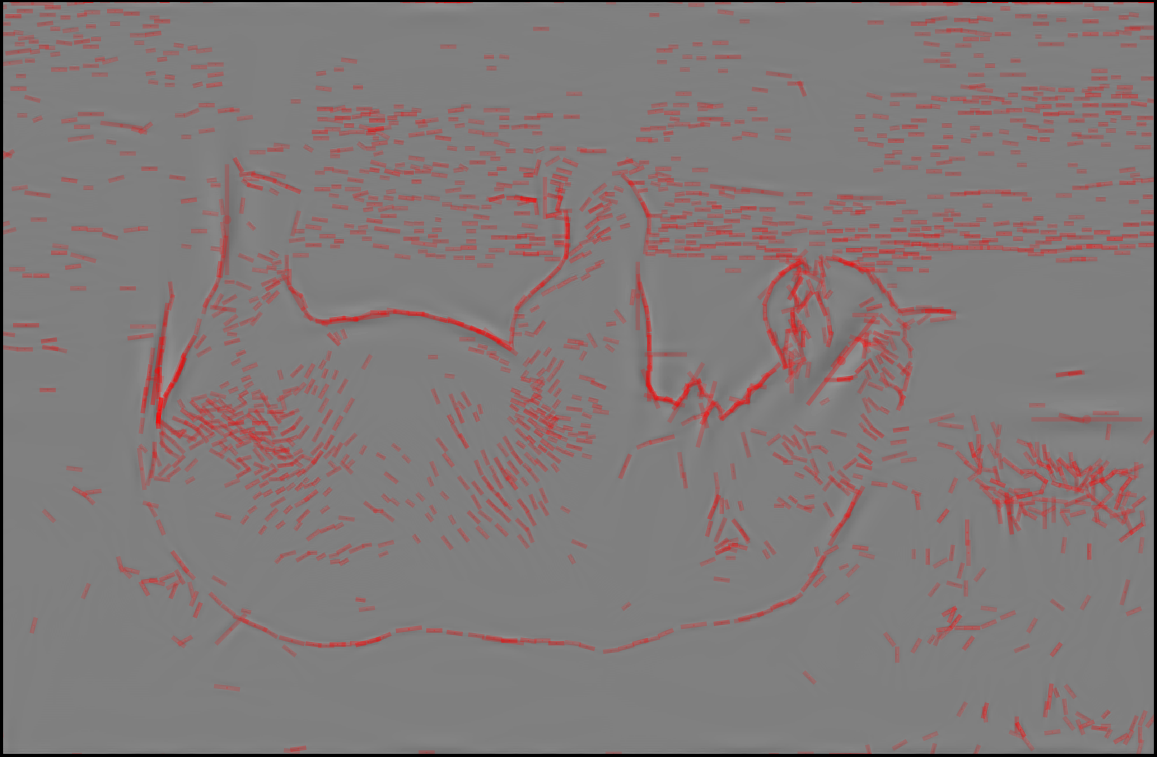

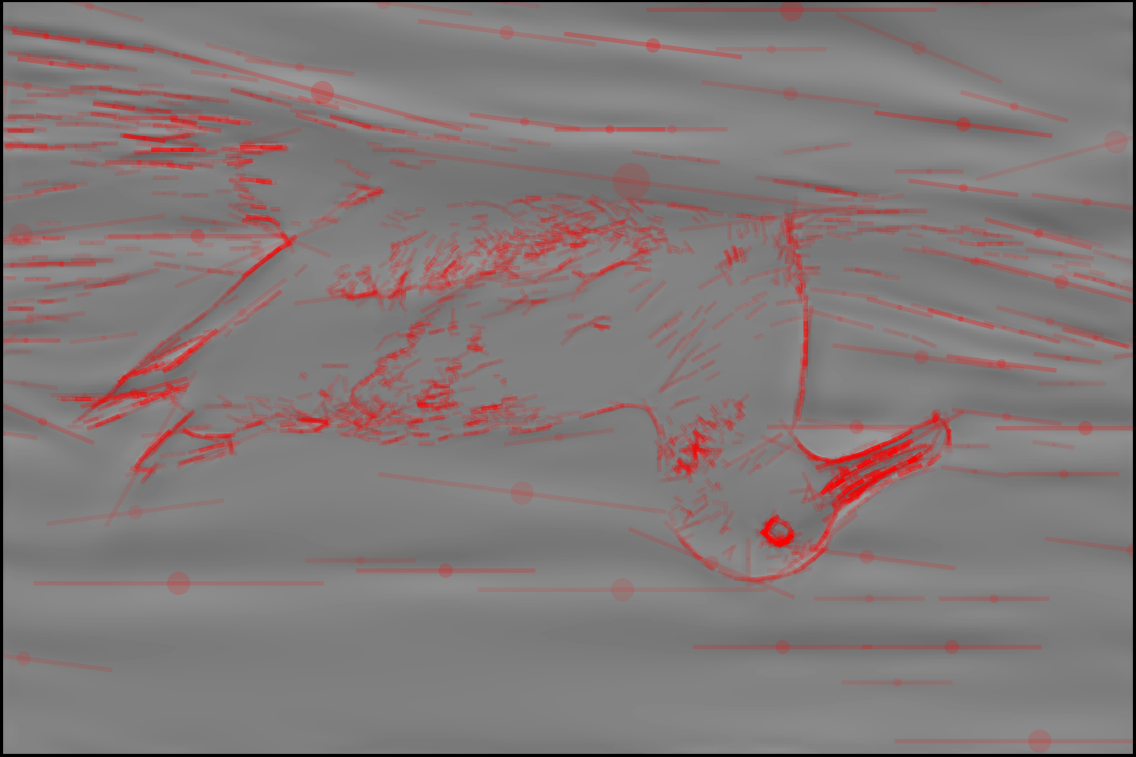

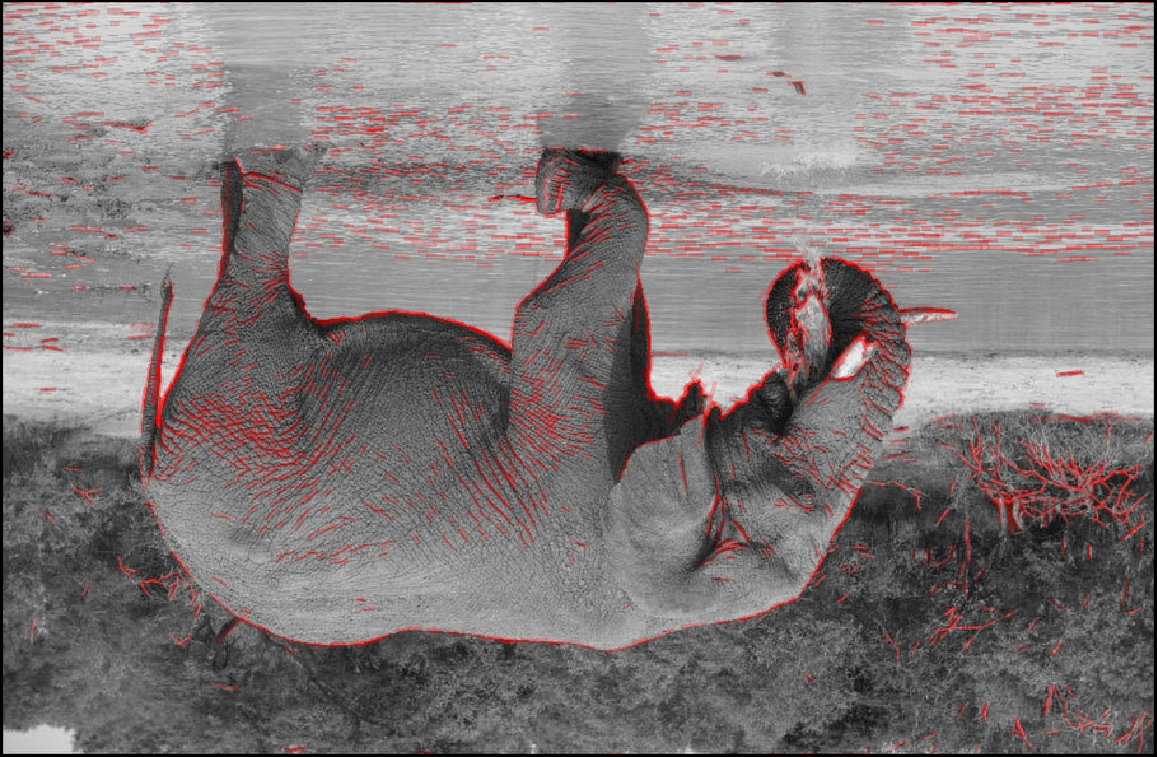

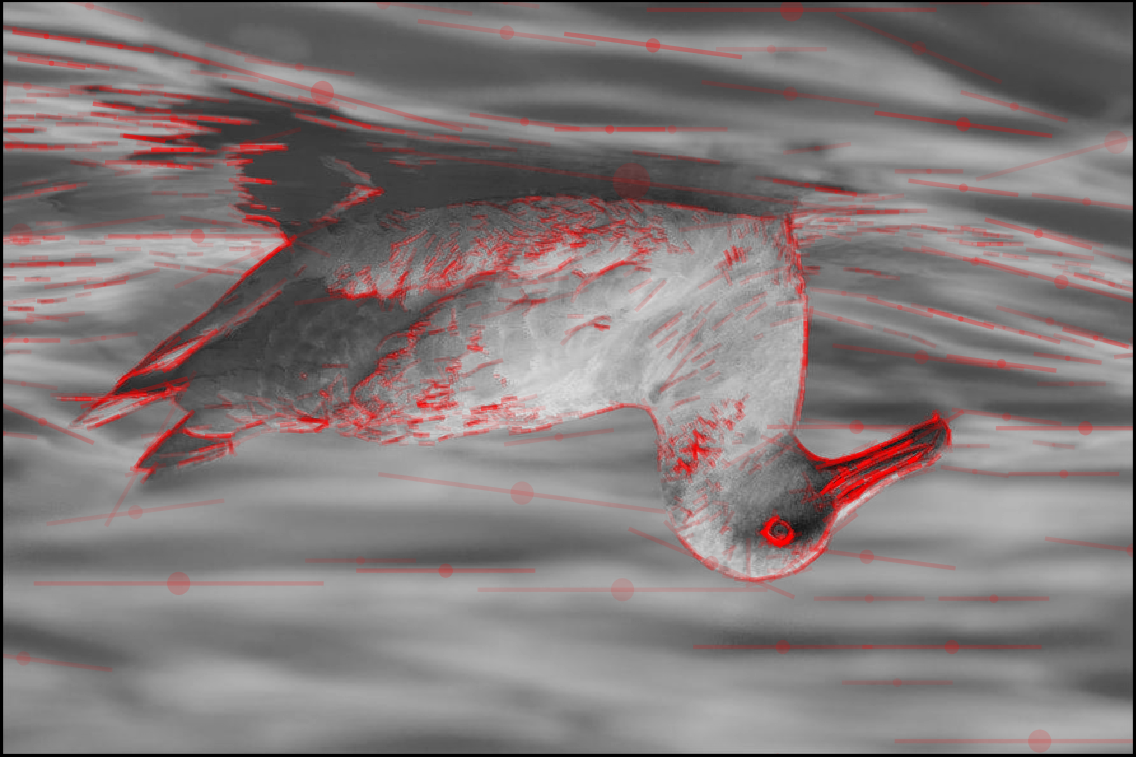

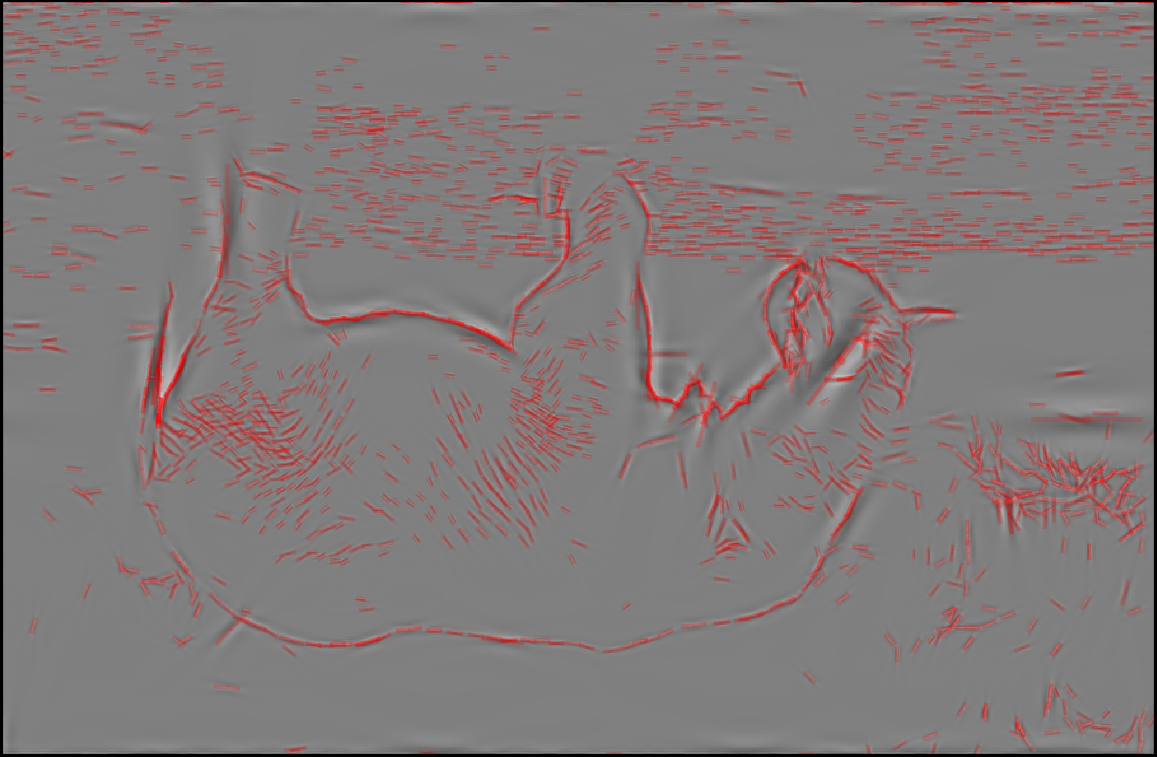

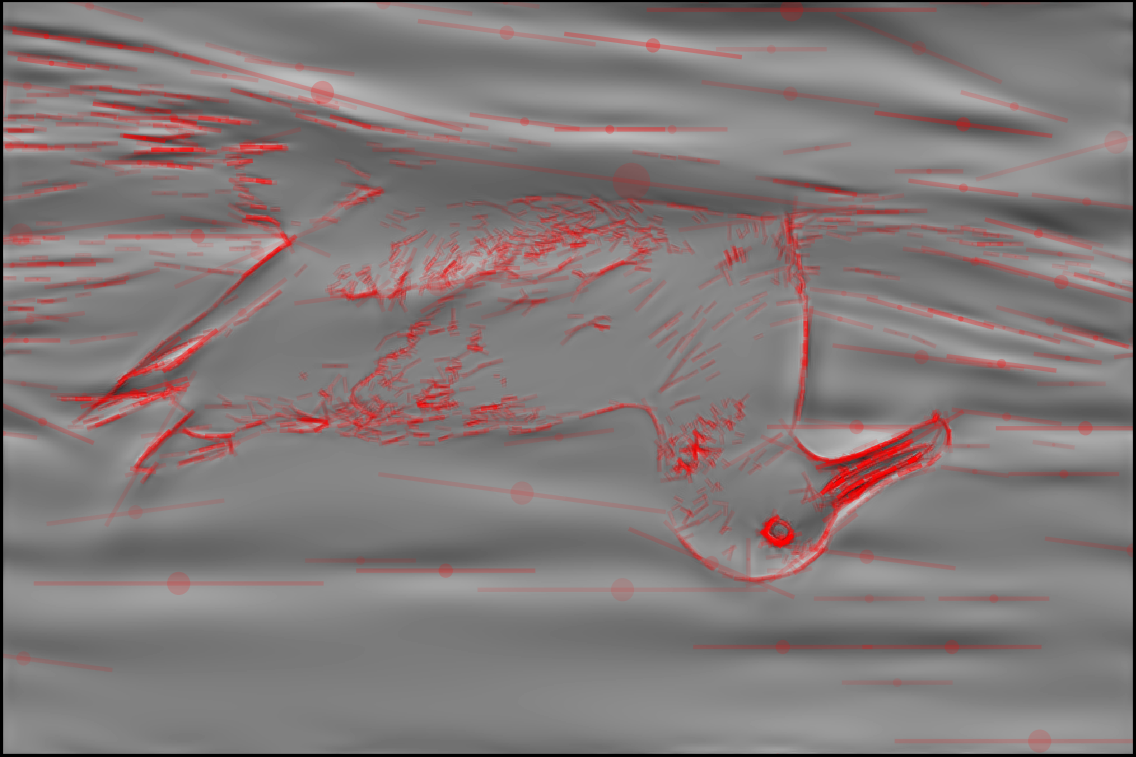

In [6]:
from IPython.display import display, Image

for figtype in ['', '_edge', '_rec']:
    for filename in ['elephant.jpg', 'bird.jpg']:#'zebra.jpg', 'duck.jpg', 'duck2.jpg', , 'seagull.jpg']:
        try: display(Image(filename='./results/example_' + filename.replace('.', '_') + figtype + '.png'))
        except Exception: pass

## Schematics for edge co-occurences and  second-order statistics

In [7]:
import tikzmagic

ModuleNotFoundError: No module named 'tikzmagic'

In [ ]:
%%tikz  -p 'tkz-euclide' -x '\usetkzobj{{all}}' -e ../figures/diagram.pdf

\begin{scope}[scale=5/13]
%\fill[white,fill opacity=.9] (0, 1.2) rectangle (13, 8);
%\tkzInit[xmax=13, ymax=8]

%----------------------------------------------------------
% Defining coordinates
%----------------------------------------------------------

\tkzDefPoint(2.95, 2.25){A}
\tkzLabelPoints[above left](A)
\tkzDefPoint(10.95, 5.3){B} % HACK
\tkzLabelPoints[above==3pt](B){$o$} % HACK
\tkzDefPoint(11,5.25){B}
\tkzDefPoint(10, 2.25){C}

% draw red dots at the center of edges
\tkzDrawPoints[size=10, color=red, fill=red](A,B)

%----------------------------------------------------------
% Drawing the lines and segments
%----------------------------------------------------------
\tkzDrawLine[color=red,line width=2pt, add=-1.15 and -.15 ](C,A)
\tkzDrawLine[color=red,line width=2pt, add=-1.3 and -.3 ](C,B)

\tkzDrawLine(A,B)
\tkzDrawLines[dashed](A,C B,C)

% drawing arcs for angles  
\tkzMarkAngle[size=2.5,mkpos=.2](C,A,B)
\tkzLabelAngle[pos=3.5,circle](C,A,B){$\mathsf{\phi}$}

\tkzDefPointWith[linear,K=1.5](A,C)
\tkzGetPoint{D}
\tkzDefPointWith[linear,K=.75](B,C)
\tkzGetPoint{E}
\tkzMarkAngle[size=1,mkpos=.2](D,C,E)
\tkzLabelAngle[pos=1.75,circle](D,C,E){$\mathsf{\theta}$}

%----------------------------------------------------------
% Drawing normals
%----------------------------------------------------------

\tkzDefLine[perpendicular=through A, K=-.75](C,A)
\tkzGetPoint{a1}
\tkzDefLine[perpendicular=through B, K=2.5](C,B)
\tkzGetPoint{b1}
\tkzInterLL(a1,A)(b1,B)  \tkzGetPoint{H}
\tkzMarkRightAngle[size=.5](H,A,C)
\tkzMarkRightAngle[size=.5](H,B,C)
\tkzDrawLines[dashed,dash phase=1.5pt](a1,A)
\tkzDrawLines[dashed,dash phase=0.5pt](b1,B)

%----------------------------------------------------------
% Drawing mediator and psi line
%----------------------------------------------------------
%    \tkzDefLine[mediator](A,B)          \tkzGetPoints{m1}{M}
\tkzDefMidPoint(A,B)
\tkzGetPoint{M}
\tkzDefLine[perpendicular=through M, K=.4](A,B)
\tkzGetPoint{m1}
\tkzMarkRightAngle[size=.5](B,M,m1)    

\tkzFillAngle[size=1.4,fill=blue!40](m1,M,H)
\tkzLabelAngle[pos=2,circle](m1,M,H){$\mathsf{\psi}$}%= \phi -\theta/2
\tkzDrawLines[](m1,M M,H)    

\pgfresetboundingbox
\path(1, 1) rectangle (13, 9);
\end{scope}

## Montage of the 2 subplots

In [ ]:
%%tikz  -e ../figures/figure_model.pdf

\draw [anchor=north west] (0, 10.5) node {\includegraphics[width=8cm]{../figures/figure_elephant_jpg.png}};
\draw [anchor=north west] (0, 5) node {\includegraphics[width=8cm]{../figures/diagram.pdf}};
\draw [anchor=north west,fill=white] (-.5, 10.5) node {$\mathsf{(A)}$};
\draw [anchor=north west,fill=white] (-.5, 5) node {$\mathsf{(B)}$};


In [ ]:
!convert  ../figures/figure_model.pdf  ../figures/figure_model.jpg

In [ ]:
%%tikz  -e ../figures/figure_model_ls.pdf

\begin{scope}[xscale=1,xshift=0cm]
\draw [anchor=north west] (0, 5) node {\includegraphics[width=6cm]{../figures/figure_elephant_jpg.png}};
\end{scope}
\draw [anchor=north west] (6, 4.5) node {\includegraphics[width=4cm]{../figures/diagram.pdf}};
\draw [anchor=north west,fill=white] (0, 5.5) node {$\mathsf{(A)}$};
\draw [anchor=north west,fill=white] (6, 5.5) node {$\mathsf{(B)}$};


In [ ]:
!convert  ../figures/figure_model_ls.pdf  ../figures/figure_model_ls.jpg

## version control

In [ ]:
!git status

In [ ]:
!git commit -m' figure model ' ../notebooks/2* ../figures/figure_model.* ../figures/diagram.* ; git push